# ASCAT obs_var in-situ plotter

Replicates the CYGNSS in-situ overlay plots for Err_6.4%, Err_9.0%, CNTL.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import t
from pathlib import Path

# Plot look
palette = {"SCAN": "#0072B2", "USCRN": "#E69F00", "SMAP Core": "#009E73"}
markers = {"SCAN": "o", "USCRN": "s", "SMAP Core": "^"}
title_fs = 15
label_fs = 11
tick_fs  = 10
legend_fs = 12
dot_size = 70
capsize = 2


In [2]:
DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var')

experiments = [
    {"prefix": "LS_OLv8_M36", "label": "CNTL"},
    {"prefix": "LS_DAv8_M36_obs_var_9", "label": "Err_9.0%"},
    {"prefix": "LS_DAv8_M36_obs_var_64", "label": "Err_6.4%"},
]

networks = [
    ("_SCAN_SM_1d_c1234smv_5yr", "SCAN"),
    ("_USCRN_SM_1d_c1234smv_5yr", "USCRN"),
    ("_CalVal_M33_SM_1d__5yr", "SMAP Core"),
]

panel_info_means = [
    ("R",      r"$R$ (-)",                (0.50, 0.90)),
    ("anomR",  r"anomR (-)",              (0.50, 0.90)),
    ("ubRMSE", r"ubRMSD ($m^3 m^{-3}$)",  (0.015, 0.060)),
]

panel_info_delta = [
    ("R",      r"Δ$R$ (EXP − CNTL)",                      (-0.05, 0.20)),
    ("anomR",  r"ΔanomR (EXP − CNTL)",                    (-0.05, 0.20)),
    ("ubRMSE", r"ΔubRMSD (CNTL − EXP) $m^3 m^{-3}$",     (-0.006, 0.012)),
]


In [3]:
def reduce_metric_means_ci(arr, lo, up):
    mean = np.nanmean(arr, axis=0)
    n = np.sum(~np.isnan(arr), axis=0)
    denom = np.sqrt(np.maximum(n, 1))
    ci_lo = np.nanmean(lo, axis=0) / denom
    ci_up = np.nanmean(up, axis=0) / denom
    ci_mag = np.vstack([np.abs(ci_lo), np.abs(ci_up)])
    return mean, ci_mag, n

def paired_delta_stats(arr_cntl, arr_exp, up_is_better=True, alpha=0.05):
    sign = +1 if up_is_better else -1
    D = sign * (arr_exp - arr_cntl)
    mask = (~np.isnan(arr_cntl)) & (~np.isnan(arr_exp))
    depth = arr_cntl.shape[1]
    mean_delta = np.full(depth, np.nan)
    ci_half = np.full(depth, 0.0)
    n_eff = np.zeros(depth, dtype=int)
    for d in range(depth):
        m = mask[:, d]
        if not np.any(m):
            continue
        di = D[m, d]
        n = di.size
        n_eff[d] = n
        dbar = np.nanmean(di)
        sd = np.nanstd(di, ddof=1) if n > 1 else 0.0
        se = sd / np.sqrt(max(n, 1))
        k = t.ppf(1 - alpha/2, df=max(n-1, 1))
        mean_delta[d] = dbar
        ci_half[d] = k * se
    return mean_delta, ci_half, n_eff


def plot_overlay(means_dict, cis_dict, Ns_dict, panel_info, outfile,
                 expt_idx=None, x_tick_labels=None):
    num_networks = len(networks)
    all_idx = np.arange(len(experiments))
    if expt_idx is None:
        expt_idx = all_idx
    expt_idx = np.asarray(expt_idx)
    if x_tick_labels is None:
        x_tick_labels = [experiments[i]['label'] for i in expt_idx]

    fig = plt.figure(figsize=(12.5, 7.6), constrained_layout=True)
    mosaic = [
        ["legend", "legend", "legend"],
        ["s0", "s1", "s2"],
        ["r0", "r1", "r2"],
    ]
    axs = fig.subplot_mosaic(mosaic, gridspec_kw={"height_ratios": [0.14, 1.0, 1.0]})
    labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
    label_keys = ["s0", "s1", "s2", "r0", "r1", "r2"]
    for lab, key in zip(labels, label_keys):
        axs[key].text(0.02, 0.97, lab, transform=axs[key].transAxes,
                      fontsize=12, fontweight="normal", va="top", ha="left")
    ax_leg = axs["legend"]; ax_leg.axis("off")

    x = np.arange(len(expt_idx))
    offsets = np.linspace(-0.18, 0.18, num_networks)

    for col, (metric_key, ylab, ylim) in enumerate(panel_info):
        for depth in [0, 1]:
            ax = axs[("s" if depth == 0 else "r") + str(col)]
            ax.grid(axis="y", color="lightgrey", zorder=0)
            ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.7, zorder=1)
            ax.set_axisbelow(True)

            for ni, (_, nlabel) in enumerate(networks):
                y  = means_dict[metric_key][ni, depth, expt_idx]
                xpos = x + offsets[ni]

                ci = np.asarray(cis_dict[metric_key][ni, :, depth, expt_idx], dtype=float)
                if ci.ndim == 0:
                    val = float(ci); ci = np.array([[val],[val]])
                elif ci.ndim == 1:
                    ci = np.vstack([ci, ci])
                elif ci.ndim == 2 and ci.shape[0] != 2:
                    ci = ci.T

                ax.scatter(xpos, y, s=dot_size, marker=markers[nlabel],
                           color=palette[nlabel], edgecolor="none", zorder=3,
                           label=nlabel if (depth==0 and col==0) else None)
                ax.errorbar(xpos, y, yerr=ci, fmt="none", ecolor="gray",
                            elinewidth=1.0, capsize=capsize, zorder=2)

            ax.set_ylim(*ylim)
            if depth == 1:
                ax.set_xticks(x, x_tick_labels, fontsize=tick_fs)
            else:
                ax.set_xticks(x, [""] * len(x_tick_labels))

            layer = "Surface" if depth == 0 else "Rootzone"
            ax.set_ylabel(f"{layer} {ylab}", fontsize=label_fs)

            ntext = " | ".join(
                f"{networks[ni][1]} n={int(Ns_dict[metric_key][ni, depth, 0])}"
                for ni in range(num_networks)
            )
            ax.set_title(ntext, fontsize=10)

    handles, labels = axs["s0"].get_legend_handles_labels()
    if handles:
        ax_leg.legend(handles, labels, loc="center", ncols=len(labels),
                      fontsize=legend_fs, frameon=False, handletextpad=0.6, borderaxespad=0.0)

    fig.savefig(outfile, dpi=300, bbox_inches="tight", pad_inches=0.04)
    plt.show()


In [4]:
metrics = ["R", "anomR", "ubRMSE"]
num_expts = len(experiments)
num_networks = len(networks)

store_R = [[None]*num_expts for _ in range(num_networks)]
store_anomR = [[None]*num_expts for _ in range(num_networks)]
store_ub = [[None]*num_expts for _ in range(num_networks)]

means_raw = {m: np.full((num_networks, 2, num_expts), np.nan) for m in metrics}
cis_raw   = {m: np.full((num_networks, 2, 2, num_expts), np.nan) for m in metrics}
Ns_raw    = {m: np.zeros((num_networks, 2, num_expts), dtype=int) for m in metrics}

for ni, (tag, nlabel) in enumerate(networks):
    for ei, ex in enumerate(experiments):
        stats_path = DATA_DIR / f"{ex['prefix']}{tag}_stats.mat"
        if not stats_path.exists():
            stats_path = DATA_DIR / f"{ex['prefix']}{tag}_stats.mat"  # keep identical, but allow edit if needed
        mat = sio.loadmat(stats_path, squeeze_me=False)
        R       = np.asarray(mat["R"])
        RLO     = np.asarray(mat["RLO"])
        RUP     = np.asarray(mat["RUP"])
        anomR   = np.asarray(mat["anomR"])
        anomRLO = np.asarray(mat["anomRLO"])
        anomRUP = np.asarray(mat["anomRUP"])
        ub      = np.asarray(mat["ubRMSE"])
        ubLO    = np.asarray(mat["ubRMSELO"])
        ubUP    = np.asarray(mat["ubRMSEUP"])

        store_R[ni][ei]     = R
        store_anomR[ni][ei] = anomR
        store_ub[ni][ei]    = ub

        for key, arrs in {
            "R":      (R, RLO, RUP),
            "anomR":  (anomR, anomRLO, anomRUP),
            "ubRMSE": (ub, ubLO, ubUP),
        }.items():
            m, ci2, n = reduce_metric_means_ci(*arrs)
            means_raw[key][ni, :, ei] = m
            cis_raw[key][ni, :, :, ei] = ci2
            Ns_raw[key][ni, :, ei] = n


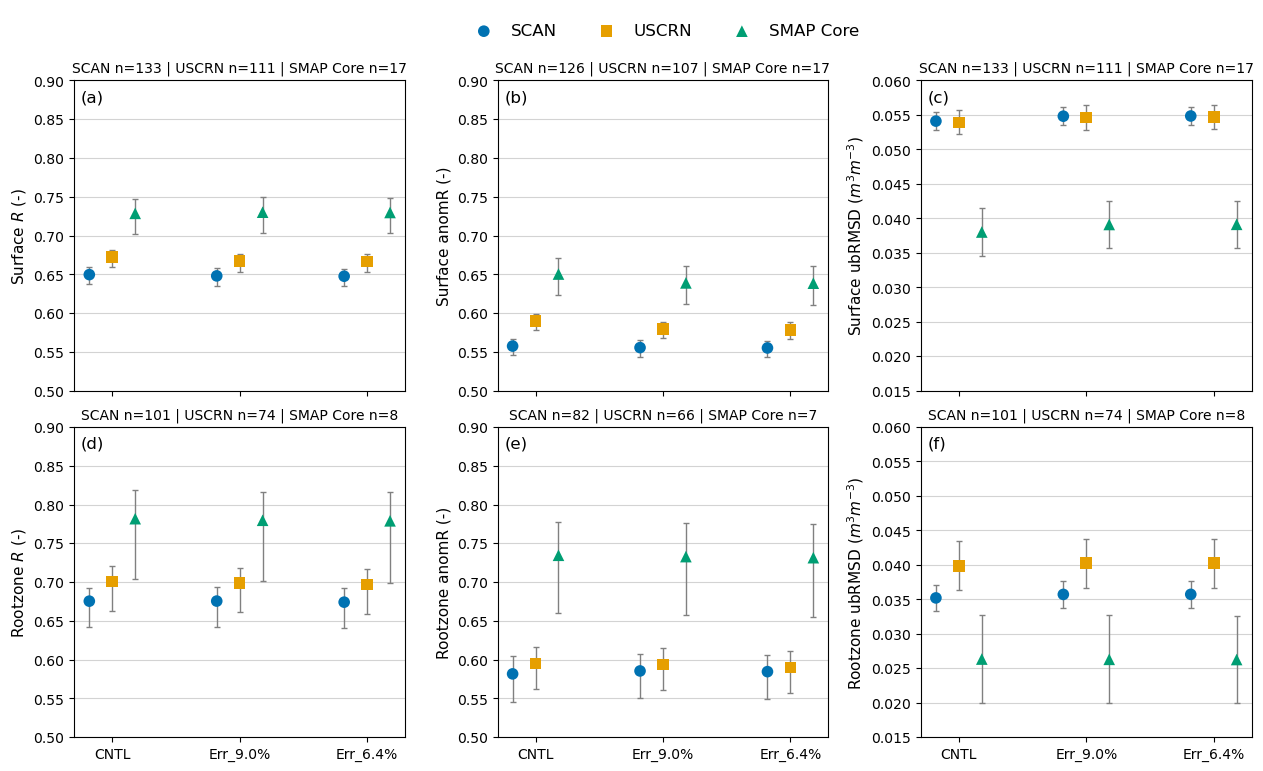

In [5]:
plot_overlay(means_raw, cis_raw, Ns_raw, panel_info_means,
             'obs_var_insitu_raw_overlay.png')


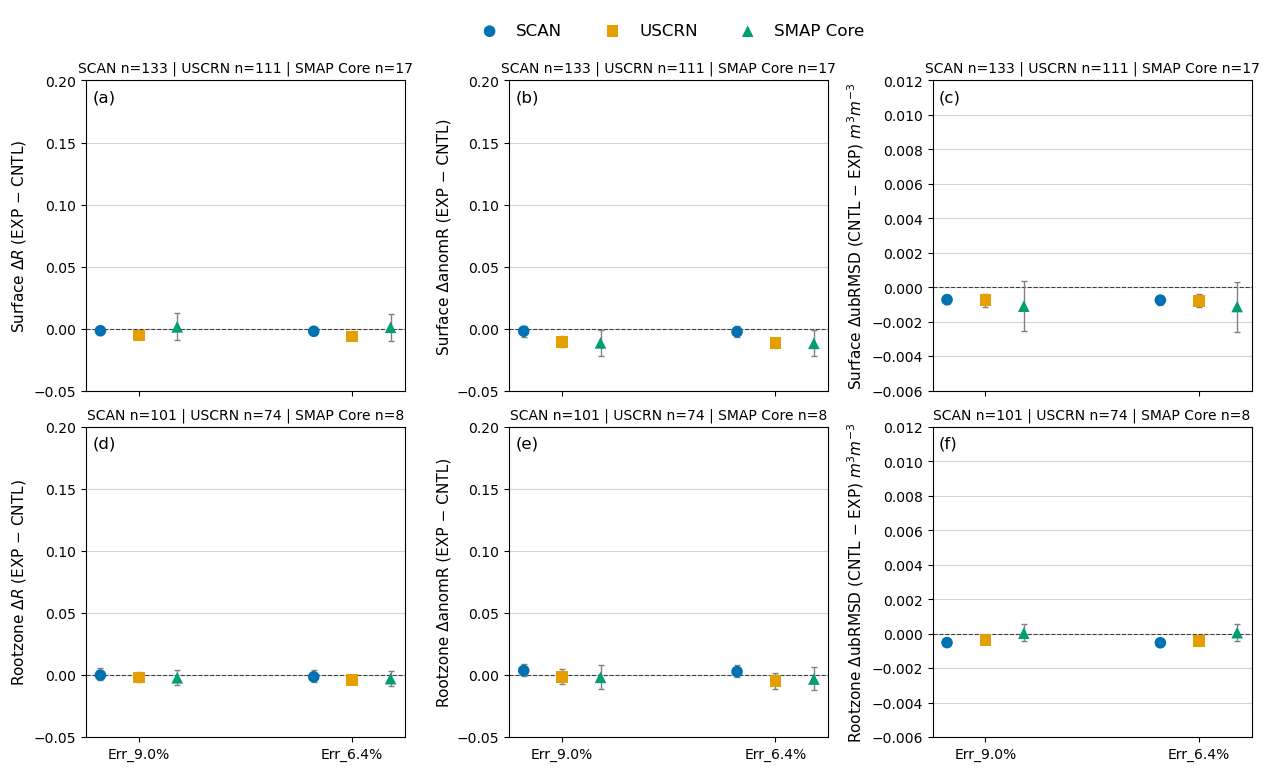

In [6]:
delta_means = {m: np.zeros_like(means_raw[m]) for m in metrics}
delta_cis   = {m: np.zeros_like(cis_raw[m])   for m in metrics}
Ns_delta    = {m: np.zeros_like(Ns_raw[m])    for m in metrics}

for ni in range(num_networks):
    R_cntl     = store_R[ni][0]
    anomR_cntl = store_anomR[ni][0]
    ub_cntl    = store_ub[ni][0]
    for key in metrics:
        delta_means[key][ni, :, 0] = 0.0
        delta_cis[key][ni, :, :, 0] = 0.0
        Ns_delta[key][ni, :, 0] = np.sum(~np.isnan(store_R[ni][0]), axis=0)
    for ei in range(1, num_expts):
        md, hw, n = paired_delta_stats(R_cntl, store_R[ni][ei], up_is_better=True)
        delta_means["R"][ni, :, ei] = md
        delta_cis["R"][ni, 0, :, ei] = hw; delta_cis["R"][ni, 1, :, ei] = hw
        Ns_delta["R"][ni, :, ei] = n

        md, hw, n = paired_delta_stats(anomR_cntl, store_anomR[ni][ei], up_is_better=True)
        delta_means["anomR"][ni, :, ei] = md
        delta_cis["anomR"][ni, 0, :, ei] = hw; delta_cis["anomR"][ni, 1, :, ei] = hw
        Ns_delta["anomR"][ni, :, ei] = n

        md, hw, n = paired_delta_stats(ub_cntl, store_ub[ni][ei], up_is_better=False)
        delta_means["ubRMSE"][ni, :, ei] = md
        delta_cis["ubRMSE"][ni, 0, :, ei] = hw; delta_cis["ubRMSE"][ni, 1, :, ei] = hw
        Ns_delta["ubRMSE"][ni, :, ei] = n

plot_overlay(
    delta_means, delta_cis, Ns_delta, panel_info_delta,
    'obs_var_insitu_delta_overlay.png',
    expt_idx=[1,2],
    x_tick_labels=[experiments[i]['label'] for i in [1,2]]
)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_23789/1003012502.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(levels)-1)


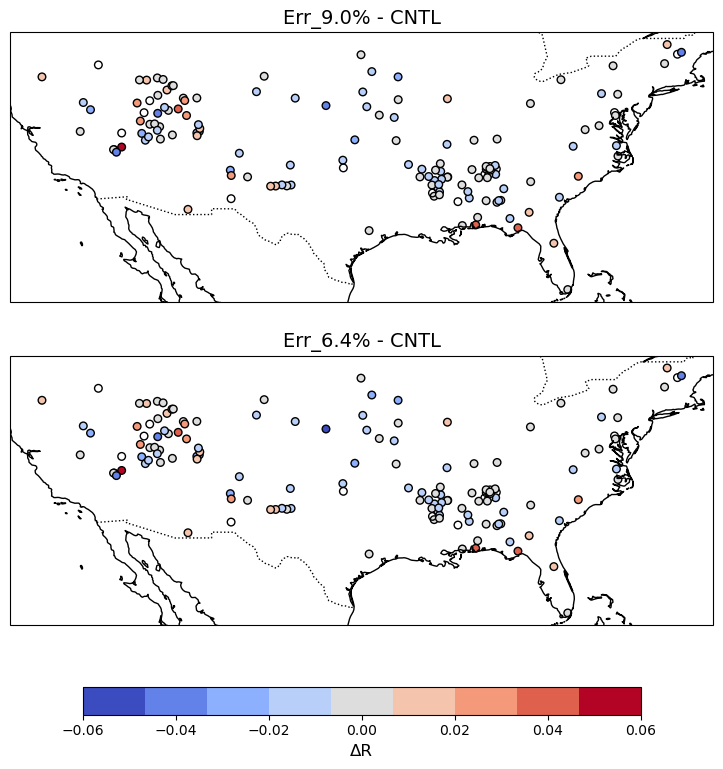

In [7]:
# Example: map site-level R differences for SCAN
import cartopy.crs as ccrs
import cartopy.feature as cfeature

insitu_tag = "_SCAN_SM_1d_c1234smv_5yr"
network_idx = next(i for i,(tag,_) in enumerate(networks) if tag==insitu_tag)
R = np.stack(store_R[network_idx], axis=-1)

raw_path = DATA_DIR / f"{experiments[0]['prefix']}{insitu_tag}_raw_timeseries.mat"
mat_raw = sio.loadmat(raw_path, squeeze_me=False)
INSITU_lat = mat_raw['INSITU_lat'].flatten()
INSITU_lon = mat_raw['INSITU_lon'].flatten()

R_diff_surface_9 = R[:,0,1] - R[:,0,0]
R_diff_surface_64 = R[:,0,2] - R[:,0,0]

levels = np.linspace(-0.06, 0.06, 10)
cmap = plt.cm.get_cmap('coolwarm', len(levels)-1)

fig, axs = plt.subplots(2, 1, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, diff_data, title in zip(
    axs,
    [R_diff_surface_9, R_diff_surface_64],
    ['Err_9.0% - CNTL', 'Err_6.4% - CNTL']
):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    sc = ax.scatter(INSITU_lon, INSITU_lat, c=diff_data, cmap=cmap, s=30, edgecolor='k',
                    transform=ccrs.PlateCarree(), vmin=levels[0], vmax=levels[-1])
    ax.set_title(title, fontsize=14)

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=levels[0], vmax=levels[-1]), cmap=cmap),
                    ax=axs, orientation='horizontal', shrink=0.6, pad=0.08)
cbar.set_label('ΔR', fontsize=12)
plt.show()
